# Visualize the filters

In [2]:
import torch
import torchvision.models as models
from torchsummary import summary

# load the model with pretrained weights
model = models.vgg16(pretrained=True)

# summarize the model (input size: channels x height x width)
summary(model, input_size=(3, 224, 224))

c:\Users\fwilh\.conda\envs\ift\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\fwilh\.conda\envs\ift\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

The dark squares indicate small or inhibitory weights and the light squares represent large or excitatory weights. Using this intuition, we can see that the filters on the first row detect a gradient from light in the top left to dark in the bottom right.

Layer: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Weights: torch.Size([64, 3, 3, 3])


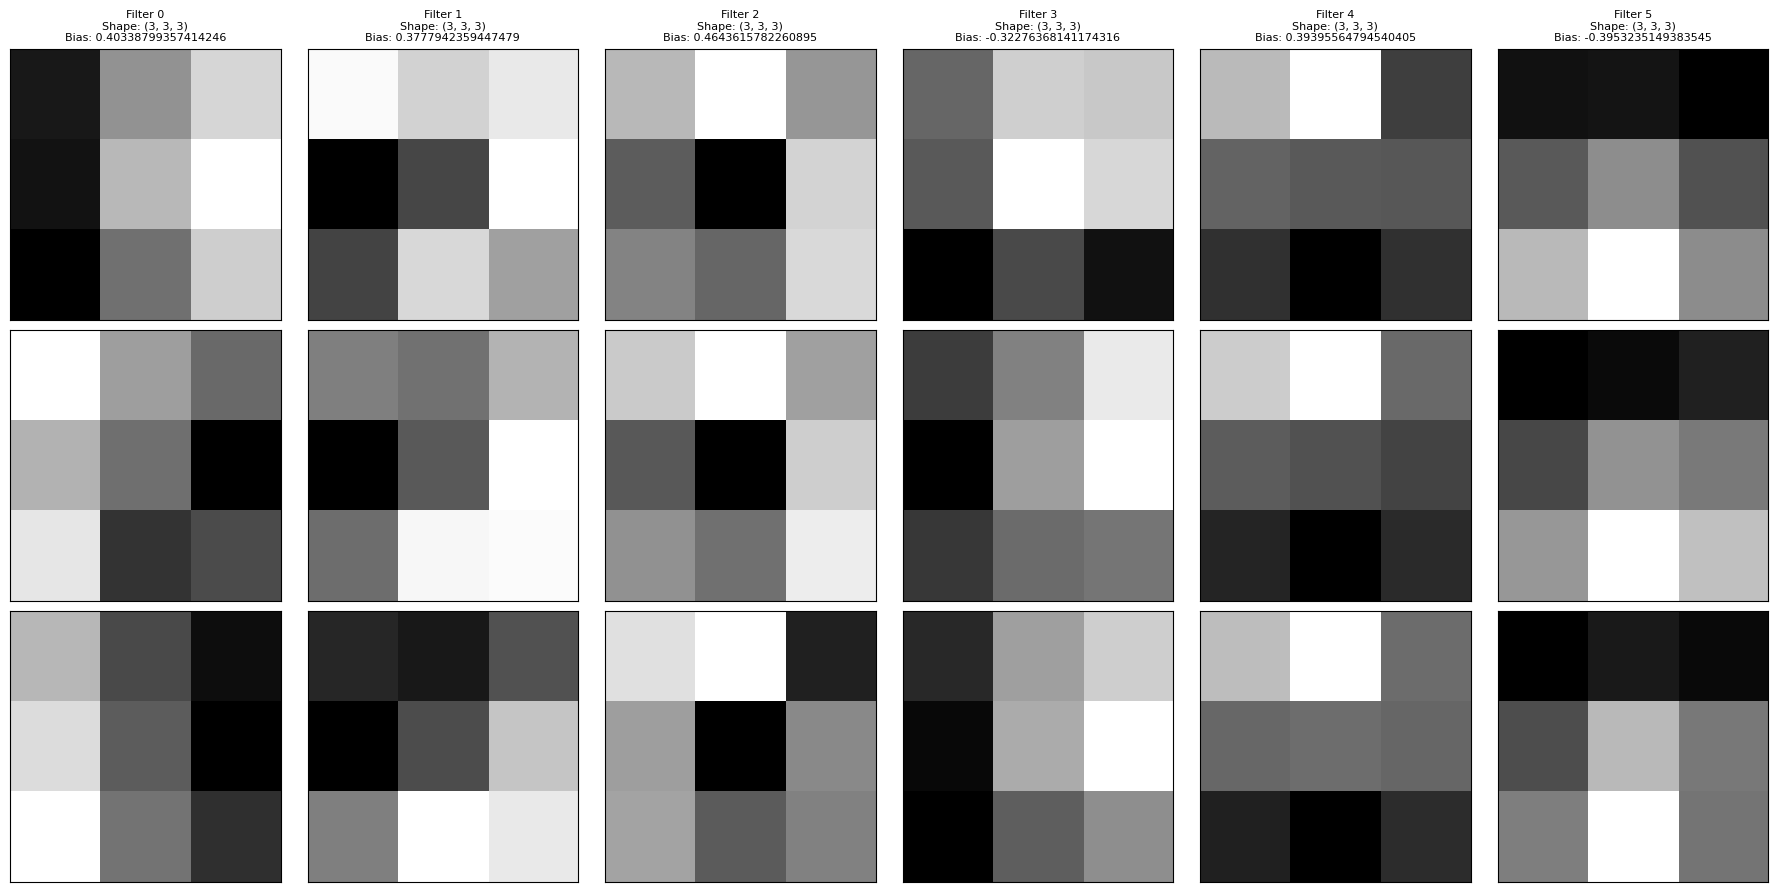

In [ ]:
import matplotlib.pyplot as plt
import torch

# Iterate over modules to find the first convolutional layer
for name, module in model.named_modules():
    if not isinstance(module, torch.nn.Conv2d):
        continue

    # Get filters and bias from the module
    filters = module.weight.data
    bias = module.bias  # could be None

    print(f'Layer: {module}, Weights: {filters.shape}')

    # Normalize filter values to 0-1 using min-max normalization
    f_max, f_min = filters.max().item(), filters.min().item()
    normalised_filters = (filters - f_min) / (f_max - f_min)

    # Define the number of filters to visualize and number of channels per filter.
    n_filters = 6
    num_channels = filters.shape[1]  # e.g., 3 for RGB

    # Create a figure with rows for channels and columns for filters.
    plt.figure(figsize=(n_filters * 3, num_channels * 3))
    
    # Iterate over each channel (row) and each filter (column).
    for channel in range(num_channels):
        for i in range(n_filters):
            ax = plt.subplot(num_channels, n_filters, channel * n_filters + i + 1)
            ax.set_xticks([])
            ax.set_yticks([])

            # Get the i-th filter; shape: (in_channels, kernel_height, kernel_width)
            f = normalised_filters[i]
            
            # For the top row (channel 0), add descriptive text as the subplot title.
            if channel == 0:
                filter_shape = tuple(f.shape)
                filter_bias = bias[i].item() if bias is not None else 'None'
                ax.set_title(f'Filter {i}\nShape: {filter_shape}\nBias: {filter_bias}', fontsize=8)
            
            # Plot the corresponding channel of the filter.
            plt.imshow(f[channel].cpu().numpy(), cmap='gray')
            
    plt.tight_layout()
    plt.show()
    plt.close()
    break


RGB visualisation can only be done for the first convolution layer because the layer layers have more than 3 channels and therefor are not in RGB anymore

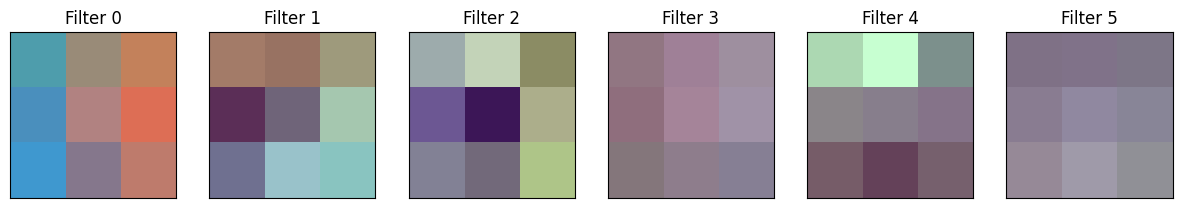

In [4]:
import matplotlib.pyplot as plt

# Iterate over modules to find the first convolutional layer
for name, module in model.named_modules():
    if not isinstance(module, torch.nn.Conv2d):
        continue

    # Get the filters (weights) of shape (out_channels, in_channels, kernel_height, kernel_width)
    filters = module.weight.data

    # Normalize filter values to 0-1 using min-max normalization
    f_min, f_max = filters.min().item(), filters.max().item()
    normalised_filters = (filters - f_min) / (f_max - f_min)

    # Plot the first few filters as RGB images
    n_filters = 6
    plt.figure(figsize=(15, 5))
    for i in range(n_filters):
        # f: shape (in_channels, kernel_height, kernel_width)
        f = normalised_filters[i]
        # Rearrange dimensions to (kernel_height, kernel_width, in_channels) for imshow
        f_rgb = f.permute(1, 2, 0).cpu().numpy()

        ax = plt.subplot(1, n_filters, i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f_rgb)
        ax.set_title(f'Filter {i}')
    plt.show()
    break


# Visualize the feature maps

torch.Size([1, 3, 224, 224])
Layer 0: Conv2d output shape: (1, 64, 224, 224)


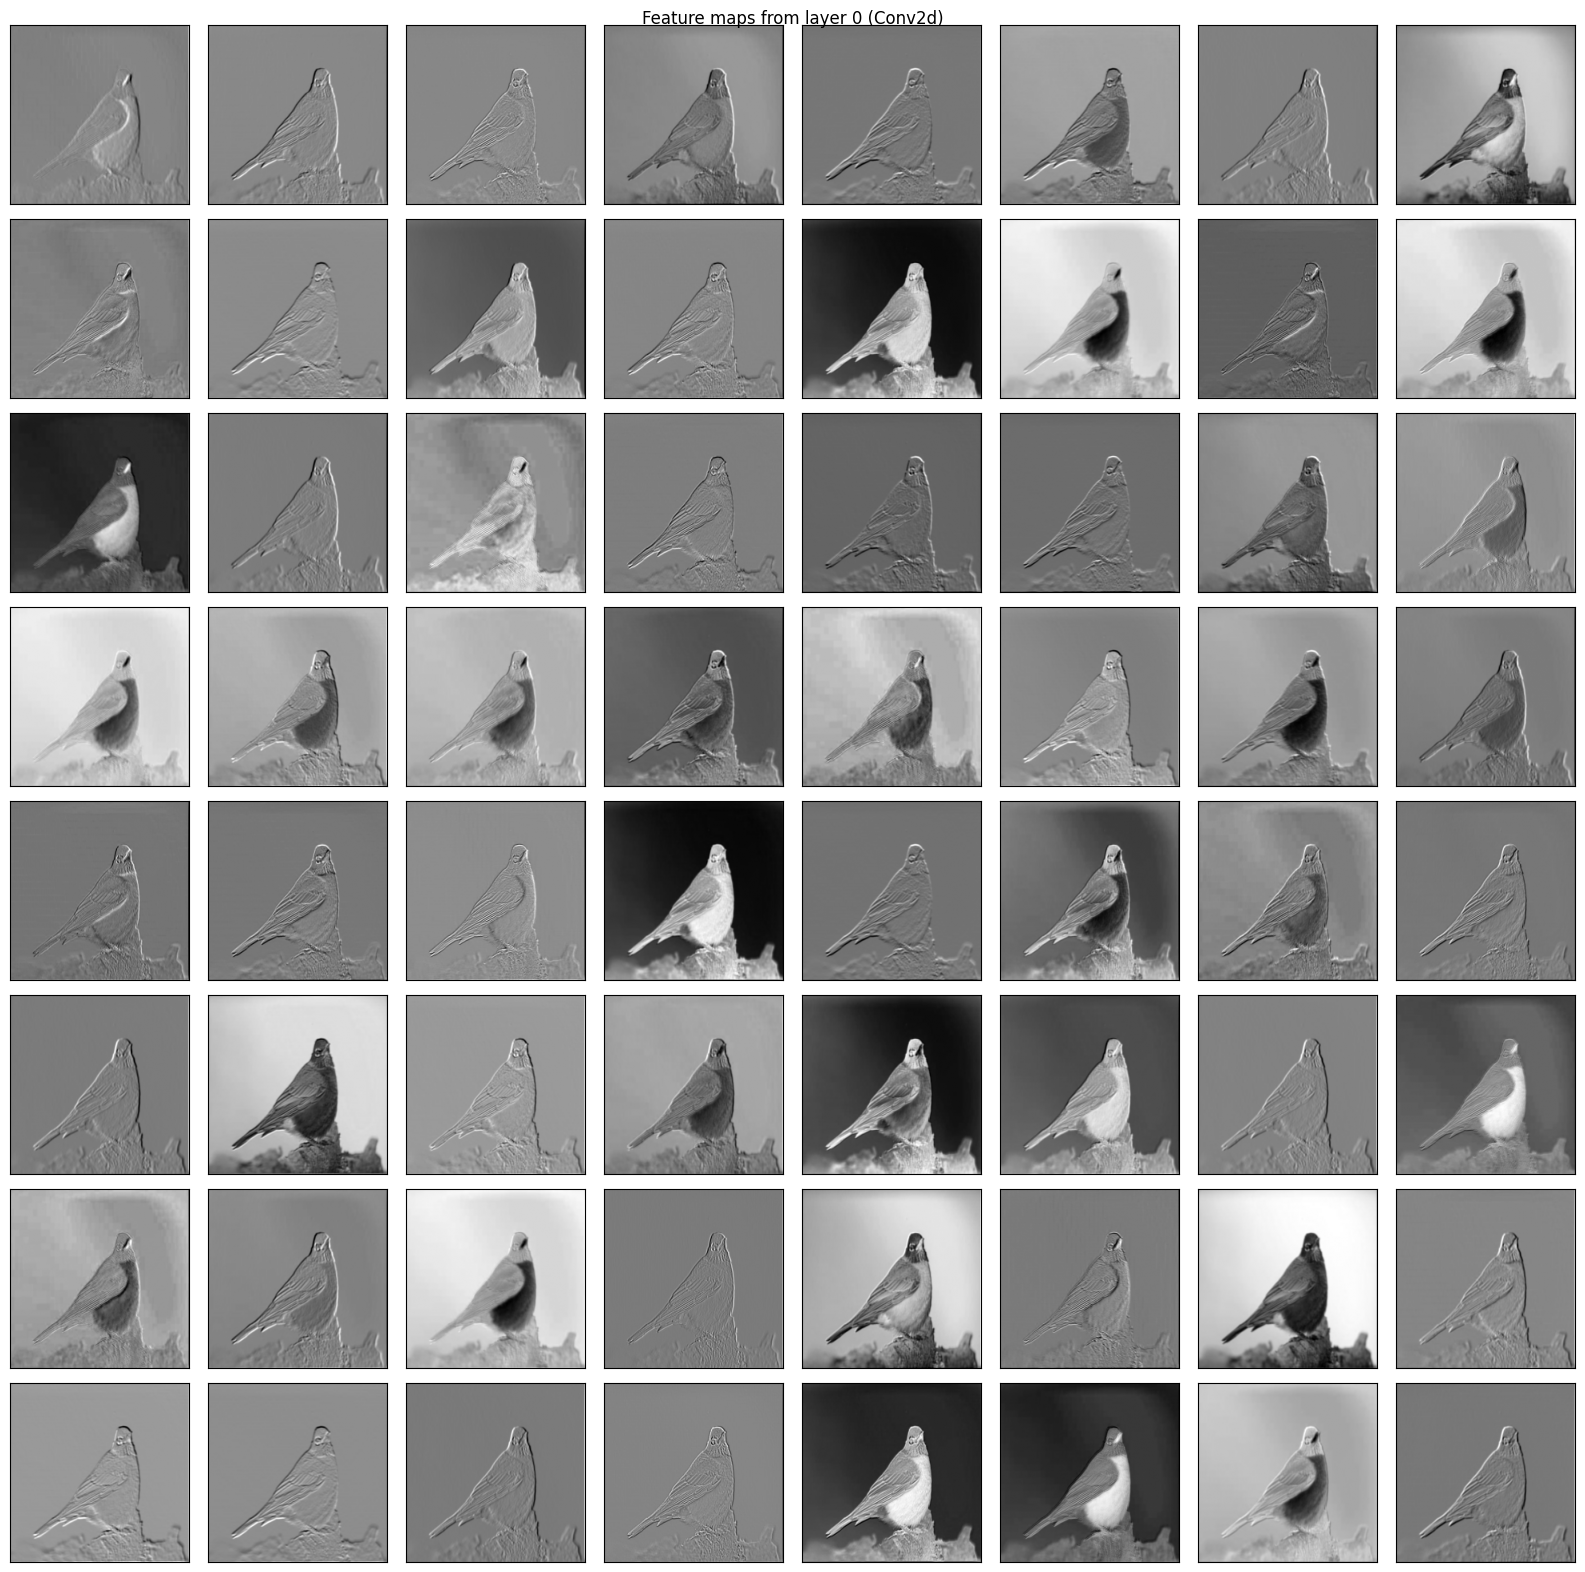

In [28]:

from PIL import Image
import torchvision.transforms as transforms

# Define a composite transform: first resize, then convert to tensor.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Open the image and apply the transform.
img = Image.open('bird.jpg')
img = transform(img).unsqueeze(0)
img = normalize(img)

# Now, img_tensor has shape (C, H, W) and pixel values in [0, 1].
print(img.shape)


# Loop through the layers in the 'features' Sequential container
for i, layer in enumerate(model.features):
    if not isinstance(layer, torch.nn.Conv2d):
        continue

    new_mod = torch.nn.Sequential(*list(model.features.children())[:i+1])
    fmap = new_mod(img).detach().cpu().numpy()
    print(f"Layer {i}: {layer.__class__.__name__} output shape: {fmap.shape}")

    
    grid_size = int(fmap.shape[1] ** 0.5)
    if grid_size * grid_size < fmap.shape[1]:
        grid_size += 1

    plt.figure(figsize=(grid_size * 2, grid_size * 2))
    for j in range(fmap.shape[1]):
        ax = plt.subplot(grid_size, grid_size, j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        # Plot the j-th feature map from the first sample in the batch.
        plt.imshow(fmap[0, j], cmap='gray')
    plt.suptitle(f"Feature maps from layer {i} ({layer.__class__.__name__})")
    plt.tight_layout()
    plt.show()

    break